# cml1 - Immobilienrechner
# 3. Klassifikation des Objekttyps

Das Ziel dieses Notebooks ist es, der Typ des Objekts zu klassifizieren. Dazu werden die Daten aus dem `datawrangling.ipynb` Datenaufbereitung verwendet.

## Metriken

In der Welt der Datenanalyse und des maschinellen Lernens sind Metriken unerlässlich, um die Leistungsfähigkeit und Genauigkeit von Klassifikationsmodellen zu bewerten. Sie ermöglichen es uns, die Effektivität unserer Modelle objektiv zu messen und Bereiche für Verbesserungen zu identifizieren. Im Folgenden werden einige der wichtigsten Metriken vorgestellt, die üblicherweise zur Bewertung von Klassifikationsmodellen verwendet werden:

### Accuracy

Die Accuracy ist ein Mass für den Gesamtanteil der korrekt klassifizierten Objekte im Verhältnis zur Gesamtanzahl der Objekte. Sie ist besonders hilfreich in Situationen, in denen die Klassen gleichmässig verteilt sind.

<div align="center">

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

</div>

### Precision

Die Precision bewertet, wie genau die Vorhersagen des Modells sind, indem sie misst, welcher Anteil der Objekte, die als zu einer bestimmten Klasse gehörig vorhergesagt wurden, tatsächlich zu dieser Klasse gehören. Diese Metrik ist besonders wichtig in Szenarien, wo die Kosten für falsch positive Ergebnisse hoch sind.

<div align="center">

$$
Precision = \frac{TP}{TP + FP}
$$

</div>

### Recall

Der Recall gibt an, welcher Anteil der tatsächlichen Objekte einer Klasse vom Modell korrekt identifiziert wurde. Diese Metrik ist kritisch in Fällen, in denen das Übersehen von tatsächlichen Fällen schwerwiegende Konsequenzen hat.

<div align="center">

$$
Recall = \frac{TP}{TP + FN}
$$

</div>


### F1-Score

Der F1-Score ist der harmonische Mittelwert von Precision und Recall und bietet eine Balance zwischen diesen beiden Metriken. Er ist besonders nützlich, wenn ein Ausgleich zwischen Precision und Recall erforderlich ist.

<div align="center">

$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$

</div>


### Konfusionsmatrix 

Die Konfusionsmatrix bietet eine detaillierte Darstellung der korrekten und falschen Vorhersagen für jede Klasse und ist ein nützliches Werkzeug zur visuellen Analyse der Leistung eines Klassifikationsmodells.

<div align="center">

$$
Confusion\ Matrix = \begin{bmatrix} TN & FP \\ FN & TP \end{bmatrix}
$$

</div>

- **True Positive (TP)**: Ein Objekt wurde als positiv vorhergesagt und ist tatsächlich positiv.
- **True Negative (TN)**: Ein Objekt wurde als negativ vorhergesagt und ist tatsächlich negativ.
- **False Positive (FP)**: Ein Objekt wurde als positiv vorhergesagt, ist aber tatsächlich negativ.
- **False Negative (FN)**: Ein Objekt wurde als negativ vorhergesagt, ist aber tatsächlich positiv.


### ROC

Die ROC-Kurve (Receiver Operating Characteristic) ist eine grafische Darstellung der Leistung eines binären Klassifikators, der die Trade-offs zwischen den wahren positiven Raten (TPR) und den falsch positiven Raten (FPR) veranschaulicht. Sie wird häufig verwendet, um die Leistungsfähigkeit eines Klassifikationsmodells zu bewerten, wenn die Klassen ungleichmässig verteilt sind.

<div align="center">

$$
TPR = \frac{TP}{TP + FN}
$$

$$
FPR = \frac{FP}{FP + TN}
$$

</div>

### AUC-ROC

>Area Under the Receiver Operating Characteristic Curve (AUC-ROC)

Die AUC (Area Under Curve) misst die gesamte zweidimensionale Fläche unterhalb der gesamten ROC-Kurve und bietet damit ein aggregiertes Mass der Leistung über alle möglichen Klassifikationsschwellen hinweg. Eine hohe AUC-ROC deutet darauf hin, dass das Modell eine gute Trennung zwischen den Klassen erreicht, was bei ungleicher Klassenverteilung entscheidend ist.


### Matthews Korrelationskoeffizient (MCC)

Der Matthews Korrelationskoeffizient ist eine Metrik, die die Qualität der binären (zwei Klassen) Klassifikationen bewertet. Er ist besonders nützlich, wenn die Klassen ungleichmässig verteilt sind.

<div align="center">

$$
MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

</div>

## Metrik Auswahl

Bei der Bewertung von Klassifikationsmodellen mit einer ungleichen Verteilung der Immobilienarten sind bestimmte Metriken besonders aussagekräftig und sollten daher bevorzugt verwendet werden. In solchen Szenarien ist die herkömmliche Genauigkeitsmetrik (Accuracy) oft irreführend, da sie die Leistung des Modells in Bezug auf die überwiegende Klasse überbetont und die Minderheitenklasse vernachlässigt.

Wir haben uns also entschieden, uns auf diese drei spezifische Metriken zu konzentrieren, um die Leistung unserer Klassifikationsmodelle zu bewerten:

Eine der wichtigsten Metriken in diesem Kontext ist der `F1-Score`. Da er den harmonischen Mittelwert von Precision und Recall darstellt, bietet der F1-Score eine ausgewogene Bewertung der Modellleistung, indem er sowohl die Fähigkeit des Modells berücksichtigt, tatsächlich positive Fälle korrekt zu identifizieren (Recall), als auch die Genauigkeit seiner positiven Vorhersagen (Precision). Diese Balance ist besonders wichtig in Situationen, in denen sowohl die Vermeidung von falsch positiven als auch von falsch negativen Ergebnissen von Bedeutung ist.

Für eine umfassendere Bewertung ist auch die `Area Under the Receiver Operating Characteristic Curve (AUC-ROC)` von grossem Wert. Die AUC-ROC misst, wie gut das Modell zwischen den Klassen unterscheidet, unabhängig von der Schwellenwertwahl. 

Zusätzlich ist der `Matthews Korrelationskoeffizient (MCC)` eine robuste Metrik, die auch bei stark ungleich verteilten Daten effektiv ist. Der MCC berücksichtigt alle vier Werte der Konfusionsmatrix (TP, FP, TN, FN) und liefert einen ausgewogenen Score, der sowohl die Stärken als auch die Schwächen des Modells in Bezug auf alle Aspekte der Klassifikation widerspiegelt.

## Fehlerabschätzung für neue Daten

Um eine gute Abschätzung des Fehlers für neue Daten zu erhalten, insbesondere in Kontexten wie maschinellem Lernen und statistischer Modellierung, gibt es verschiedene wichtige Aspekte, die berücksichtigt werden sollten:

1. Vermeidung von Overfitting: Um Overfitting zu vermeiden, stellen wir sicher, dass unser Modell nicht nur auf den Trainingsdaten gut funktioniert, sondern auch auf neuen, unbekannten Daten. 

2. Cross-Validation: Wir verwenden Kreuzvalidierung, um eine bessere Schätzung der Modellleistung zu erhalten. 

3. Ausgewogenheit der Klassen: Ausserdem achten wir darauf, dass unser Datensatz keine starke Unausgewogenheit in den Klassen aufweist, da dies zu verzerrten Vorhersagen führen kann. 

4. Feature-Importance: Schliesslich analysieren wir, welche Merkmale am meisten zur Klassifizierung beitragen, um die Feature-Importance zu verstehen.

## Module importieren

In [205]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compose
from sklearn.compose import ColumnTransformer

# Imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Modelle
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Pipeline
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, matthews_corrcoef, roc_auc_score

## Daten laden
Zuerst laden wir Ihre Daten und bereiten sie für das Training vor. Dazu gehört das Behandeln von fehlenden Werten, das Umwandeln kategorischer Daten in numerische Werte und das Skalieren der Daten.

In [206]:
df_raw = pd.read_csv('../../data/immo_data_clean.csv', low_memory=False)
print(df_raw.shape)

(21466, 58)


## Sample

In [207]:
# # attic-flat und penthouse -> luxury-flats
# df_raw['type_unified'] = df_raw['type_unified'].replace(['attic-flat', 'penthouse', 'loft'], 'luxury-flat')

# # semi-detached-house und duplex-maisonette -> semi-detached-duplex
# df_raw['type_unified'] = df_raw['type_unified'].replace(['semi-detached-house', 'duplex-maisonette'], 'semi-detached-duplex')

# # farmhouse und rustico -> rural-property
# df_raw['type_unified'] = df_raw['type_unified'].replace(['farmhouse', 'rustico'], 'rural-property')

# # stepped-house to detached-house 
# df_raw['type_unified'] = df_raw['type_unified'].replace('stepped-house', 'detached-house')

# # studio to flat
# df_raw['type_unified'] = df_raw['type_unified'].replace('studio', 'flat')

# # Identifizieren der Typen mit einer Anzahl von weniger als 20, außer 'castle'
# types_to_replace = df_raw['type_unified'].value_counts()[(df_raw['type_unified'].value_counts() < 50) & (df_raw['type_unified'].value_counts().index != 'castle')].index.tolist()

# # Ersetzen dieser Typen durch "other"
# df_raw['type_unified'] = df_raw['type_unified'].replace(types_to_replace, 'other')

In [208]:
# remove rows with type_unified occurences under 20
df_raw = df_raw.groupby('type_unified').filter(lambda x: len(x) > 20)

## Vorverarbeitung

- Daten in Train - und Testsplit aufteilen
- Numerische Daten skalieren und kategorische Daten umwandeln

### Train Test Split

In [209]:
X = df_raw.drop(['type_unified', 'Municipality'], axis=1)
y = df_raw['type_unified']

# Aufteilung in Trainings- und Testdatensatz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-Hot-Encoding für die Spalte 'kanton'
X_train = pd.get_dummies(X_train, columns=['kanton', 'Availability_Categorized'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['kanton', 'Availability_Categorized'], drop_first=True)

# Stellen Sie sicher, dass beide Datensätze die gleichen Spalten haben
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17152, 84), (4288, 84), (17152,), (4288,))

In [210]:
# Überprüfen der Balance der Zielvariable
y_train.value_counts()

type_unified
flat                              8359
detached-house                    4177
villa                              940
semi-detached-house                649
attic-flat                         545
duplex-maisonette                  542
chalet                             531
penthouse                          500
terrace-house                      394
stepped-apartment                  173
farmhouse                          117
studio                              78
rustico                             51
stepped-house                       46
loft                                32
furnished-residential-property      18
Name: count, dtype: int64

### Imputation

In [211]:
cols = X_train.columns

imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(imputer.transform(X_test), columns=cols)

### Scorers

In [212]:
scorers = {
    'f1': make_scorer(f1_score, average='weighted'),
    'mcc': make_scorer(matthews_corrcoef),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
}

## Modellierung

Wir werden drei verschiedene Modelle verwenden, um die Immobilienobjekte zu klassifizieren:

1. MLP (Neural Network)

2. Logistic Regression

3. Random Forest Classifier

4. Hist Gradient Boosting Classifier

### 1. Multi Layer Perceptron
#### 1.1 Modell trainieren

In [213]:
mlp = MLPClassifier(random_state=42)

param_grid = {
    'alpha': [0.01, 0.1],
    'learning_rate_init': [0.01, 0.1],
    'max_iter': [2000, 3000],
    'hidden_layer_sizes': [(100, 50, 25), (100, 100, 100)]
}

results_mlp = {}

for scorer_name, scorer in scorers.items():
    print(f"Optimierung mit {scorer_name}")

    grid_search_mlp = GridSearchCV(
        mlp,
        param_grid,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_mlp.fit(X_train, y_train)
    best_model = grid_search_mlp.best_estimator_
    y_pred_mlp = best_model.predict(X_test)

    if scorer_name == 'roc_auc':
        score = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
    elif scorer_name == 'mcc':
        score = matthews_corrcoef(y_test, y_pred_mlp)
    else:
        score = f1_score(y_test, y_pred_mlp, average='weighted')

    results_mlp[scorer_name] = {
        'Beste Parameter': grid_search_mlp.best_params_,
        'Score': score,
        'Predictions': y_pred_mlp,
    }

Optimierung mit f1
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Optimierung mit mcc
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Optimierung mit roc_auc
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [214]:
for scorer_name, result in results_mlp.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])


Ergebnisse für f1:
Beste Parameter: {'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.01, 'max_iter': 2000}
Score: 0.3354083619171225

Ergebnisse für mcc:
Beste Parameter: {'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.01, 'max_iter': 2000}
Score: 0.0

Ergebnisse für roc_auc:
Beste Parameter: {'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.01, 'max_iter': 2000}
Score: 0.5


#### 1.2 Confusion Matrix

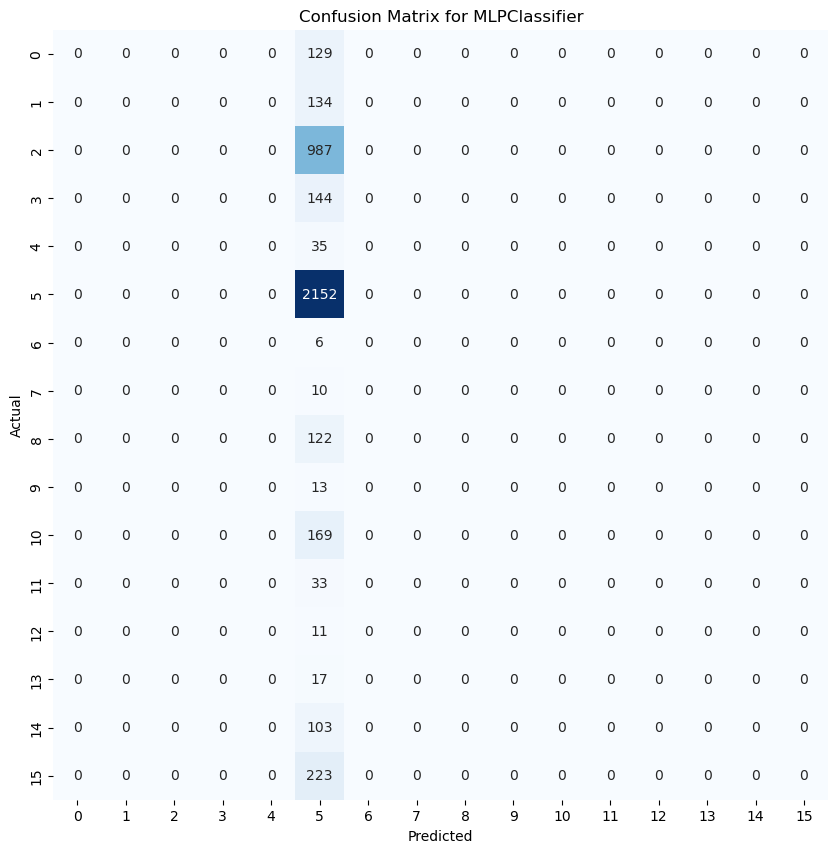

In [215]:
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLPClassifier')
plt.show()

### 2. Logistic Regression
#### 2.1 Modell trainieren

In [216]:
log_reg = LogisticRegression(random_state=42, solver='liblinear')

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'max_iter': [1000, 2000]
}

results_log_reg = {}

for scorer_name, scorer in scorers.items():
    print(f"Optimierung mit {scorer_name}")

    grid_search_log = GridSearchCV(
        log_reg,
        param_grid,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search_log.fit(X_train, y_train)
    best_model = grid_search_log.best_estimator_
    y_pred_log = best_model.predict(X_test)

    if scorer_name == 'roc_auc':
        score = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
    elif scorer_name == 'mcc':
        score = matthews_corrcoef(y_test, y_pred_log)
    else:
        score = f1_score(y_test, y_pred_log, average='weighted')

    results_log_reg[scorer_name] = {
        'Beste Parameter': grid_search_log.best_params_,
        'Score': score,
        'Predictions': y_pred_log,
    }

for scorer_name, result in results_log_reg.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])

Optimierung mit f1
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Optimierung mit mcc
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Optimierung mit roc_auc
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Ergebnisse für f1:
Beste Parameter: {'C': 10, 'max_iter': 1000, 'penalty': 'l1'}
Score: 0.5323906970703275

Ergebnisse für mcc:
Beste Parameter: {'C': 1, 'max_iter': 1000, 'penalty': 'l1'}
Score: 0.3760061399456799

Ergebnisse für roc_auc:
Beste Parameter: {'C': 1, 'max_iter': 1000, 'penalty': 'l1'}
Score: 0.8174411590320981


In [217]:
for scorer_name, result in results_log_reg.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])


Ergebnisse für f1:
Beste Parameter: {'C': 10, 'max_iter': 1000, 'penalty': 'l1'}
Score: 0.5323906970703275

Ergebnisse für mcc:
Beste Parameter: {'C': 1, 'max_iter': 1000, 'penalty': 'l1'}
Score: 0.3760061399456799

Ergebnisse für roc_auc:
Beste Parameter: {'C': 1, 'max_iter': 1000, 'penalty': 'l1'}
Score: 0.8174411590320981


#### 2.2 Confusion Matrix

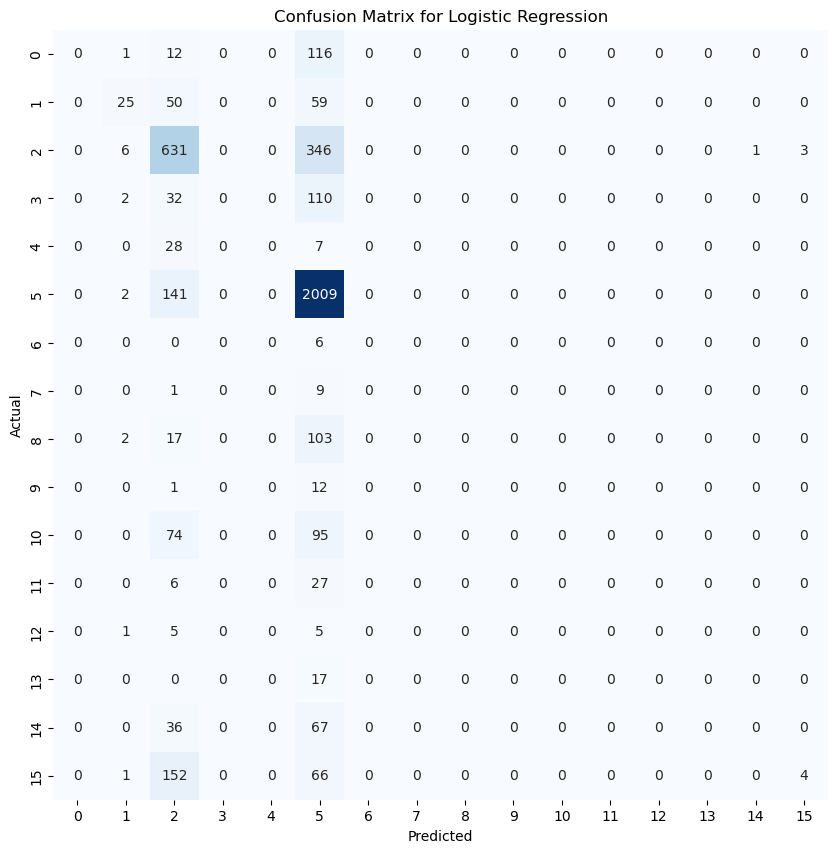

In [218]:
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

### 3. Random Forest Classifier
#### 3.1 Modell trainieren

In [221]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [20, 30],
}

results_rf = {}

for scorer_name, scorer in scorers.items():
    print(f"Optimierung mit {scorer_name}")

    grid_search_rf = GridSearchCV(
        rf,
        param_grid_rf,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search_rf.fit(X_train, y_train)
    best_model_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_model_rf.predict(X_test)

    if scorer_name == 'roc_auc':
        score_rf = roc_auc_score(y_test, best_model_rf.predict_proba(X_test), multi_class='ovr')
    elif scorer_name == 'mcc':
        score_rf = matthews_corrcoef(y_test, y_pred_rf)
    else:
        score_rf = f1_score(y_test, y_pred_rf, average='weighted')

    results_rf[scorer_name] = {
        'Beste Parameter': grid_search_rf.best_params_,
        'Score': score_rf,
        'Predictions': y_pred_rf,
    }

Optimierung mit f1
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimierung mit mcc
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimierung mit roc_auc
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [222]:
for scorer_name, result in results_rf.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])


Ergebnisse für f1:
Beste Parameter: {'max_depth': 30, 'n_estimators': 100}
Score: 0.6650989576281752

Ergebnisse für mcc:
Beste Parameter: {'max_depth': 30, 'n_estimators': 100}
Score: 0.5387994118100352

Ergebnisse für roc_auc:
Beste Parameter: {'max_depth': 20, 'n_estimators': 100}
Score: 0.8670681094130551


#### 3.2 Confusion Matrix

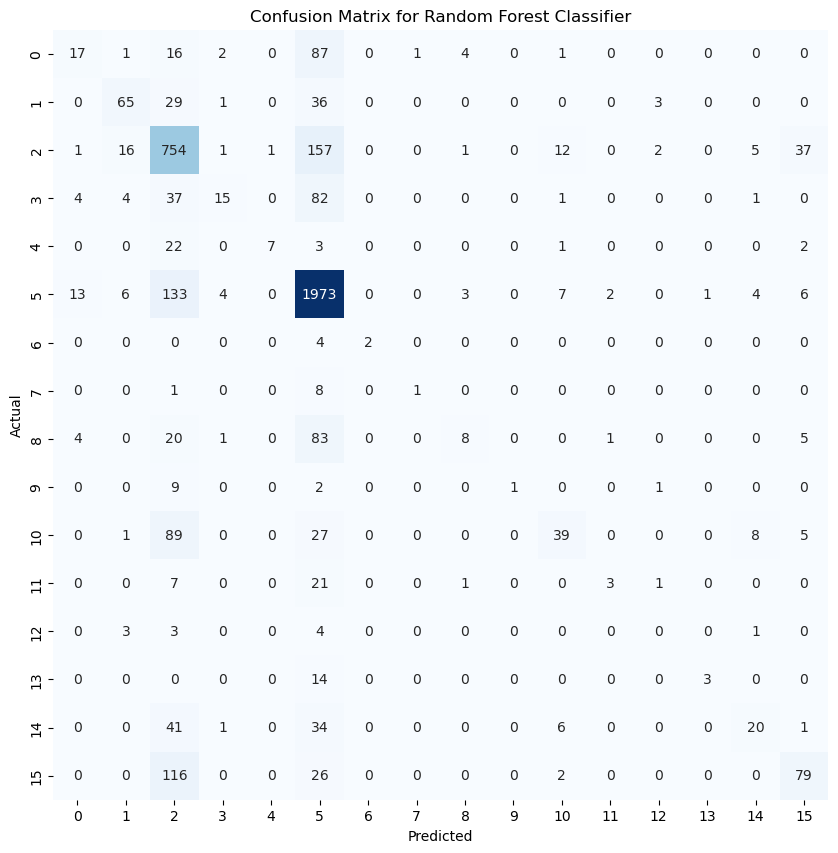

In [223]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

### 4. Hist Gradient Boosting Classifier
#### 4.1 Modell trainieren

In [225]:
hgb = HistGradientBoostingClassifier(random_state=42)

param_grid_hgb = {
    'learning_rate': [0.01, 0.1],
    'max_iter': [100, 300],
}

results_hgb = {}

for scorer_name, scorer in scorers.items():
    print(f"Optimierung mit {scorer_name}")

    random_search_hgb = GridSearchCV(
        hgb,
        param_grid_hgb,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    random_search_hgb.fit(X_train, y_train)
    best_model_hgb = random_search_hgb.best_estimator_
    y_pred_hgb = best_model_hgb.predict(X_test)

    if scorer_name == 'roc_auc':
        score_hgb = roc_auc_score(y_test, best_model_hgb.predict_proba(X_test), multi_class='ovr')
    elif scorer_name == 'mcc':
        score_hgb = matthews_corrcoef(y_test, y_pred_hgb)
    else:
        score_hgb = f1_score(y_test, y_pred_hgb, average='weighted')

    results_hgb[scorer_name] = {
        'Beste Parameter': random_search_hgb.best_params_,
        'Score': score_hgb,
        'Predictions': y_pred_hgb
    }

Optimierung mit f1
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Optimierung mit mcc
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Optimierung mit roc_auc
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [226]:
for scorer_name, result in results_hgb.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])


Ergebnisse für f1:
Beste Parameter: {'learning_rate': 0.01, 'max_iter': 300}
Score: 0.6449234372681962

Ergebnisse für mcc:
Beste Parameter: {'learning_rate': 0.01, 'max_iter': 300}
Score: 0.5176770761336924

Ergebnisse für roc_auc:
Beste Parameter: {'learning_rate': 0.01, 'max_iter': 300}
Score: 0.8843516571226747


#### 4.2 Confusion Matrix

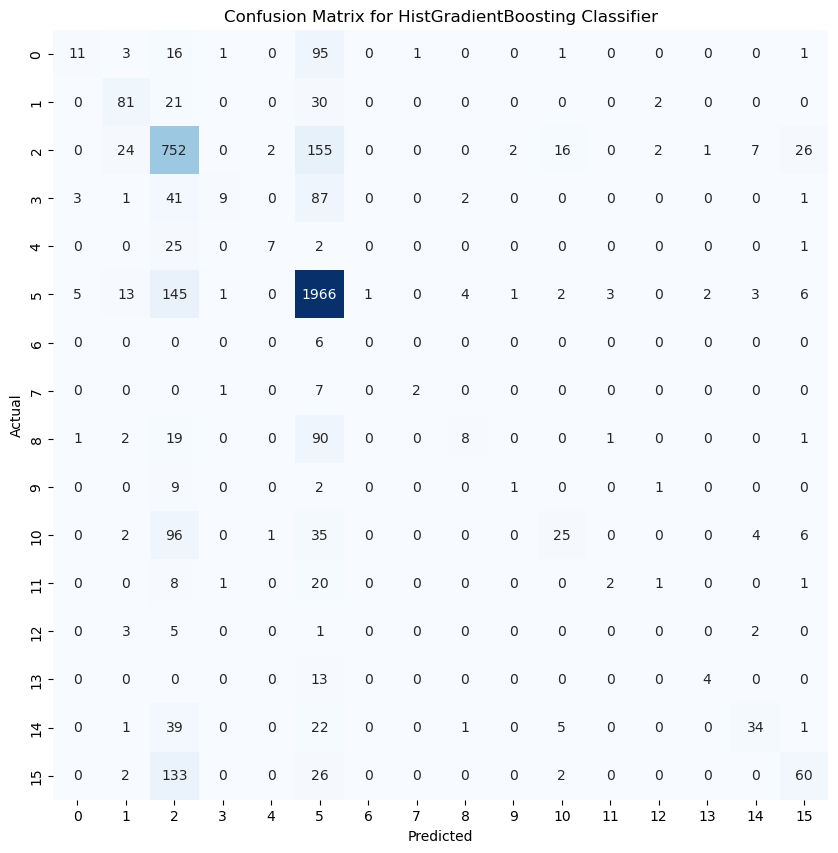

In [227]:
cm = confusion_matrix(y_test, y_pred_hgb)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for HistGradientBoosting Classifier')
plt.show()